# Project: Detection of road lane markings

In this project, lane markers shall be detected in the [Udacity Nanodegree "Self-Driving Car Engineer"](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013) dataset.
<br>
The software was developed in 2022 by Jonathan Diebel, Patrick Geiger and Georg Junemann.


In [20]:
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
import logging
import configparser

print('Welcome to the project "Recognition of lane markings".')


Welcome to the project "Recognition of lane markings".


### Global Parameters


In [21]:
# Deactivate rank warning messages for polyfit function
warnings.filterwarnings("ignore")

# number of windows for sliding windows
sliding_window_count = 180

# value for last radius
last_radius = None

# For radius calculation (pixels to meters)
y_meter_per_pixel = 30 / 720
x_meter_per_pixel = 3.7 / 1280

# Source and destination for perspective transformation
src = np.array([[598, 448], [684, 448], [1026, 668], [278, 668]], np.float32)
dst = np.array([[300, 0], [980, 0], [980, 720], [300, 720]], np.float32)

# Kernels for filter operations
kernel_small = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], 'uint8')
kernel_large = np.array([[0, 1, 1, 1, 0], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [
                        1, 1, 1, 1, 1], [0, 1, 1, 1, 0]], 'uint8')


### Basic functions for manipulation and plotting


In [22]:
# Warp image perspective to access current lane in rectangle format
def warp(img, src=src, dst=dst):
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

# Crop image to show the current lane


def crop(img, ROI):
    # Create blank img with same size as input img
    blank = np.zeros(img.shape[:2], np.uint8)

    # Fill the current lane of interest
    region_of_interest = cv2.fillPoly(blank, ROI, 255)

    # Create image of the current lane
    return cv2.bitwise_and(img, img, mask=region_of_interest)

# Merge to masks


def merge(frame, img1, img2):
    both = frame.copy()
    both[np.where(np.logical_and(img1 == 0, img2 == 0))] = 0
    return both

# Overlay two images


def overlay(img, overlay):
    img[np.where(overlay != 0)] = [0, 255, 0]
    return img

# Overlay two images with alpha value


def overlay_alpha(img, overlay):
    return cv2.addWeighted(img, 1, overlay.astype(np.uint8), 0.5, 0.0)

# Show image inside defined plot


def show_img(plt, title, img, numCols, pos, cmap):
    plt.subplot(1, numCols, pos)
    plt.title(title)
    plt.imshow(img, cmap)


# Exercise 1: Camera calibration to equalize the images

The existing images are distorted due to lens and camera characteristics. Undistort the images using the [OpenCV camera calibration routines](https://docs.opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html) and the recorded images.


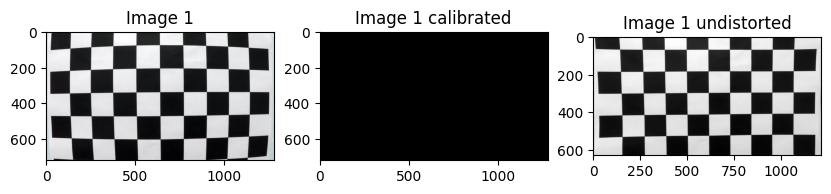

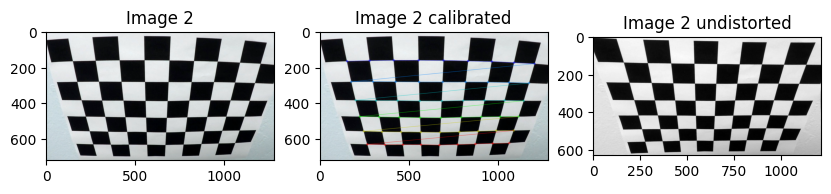

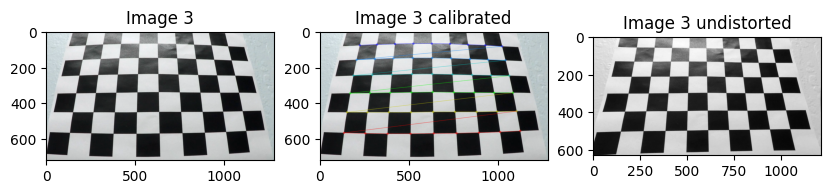

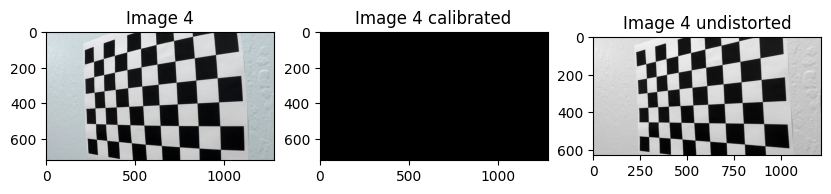

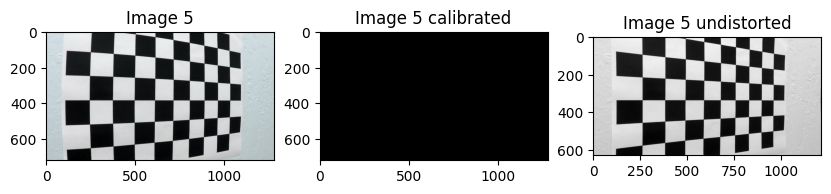

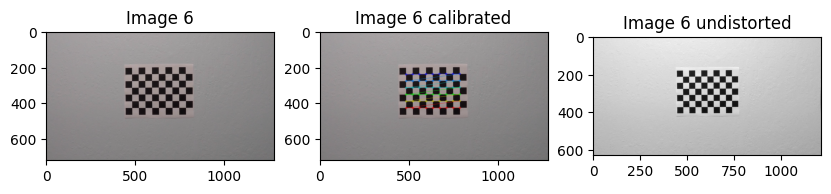

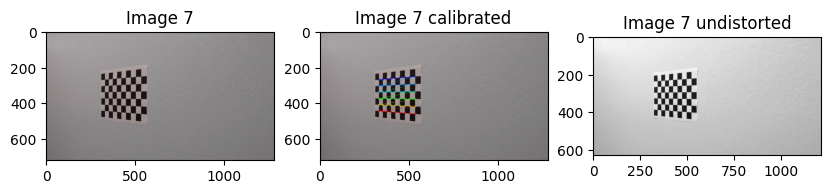

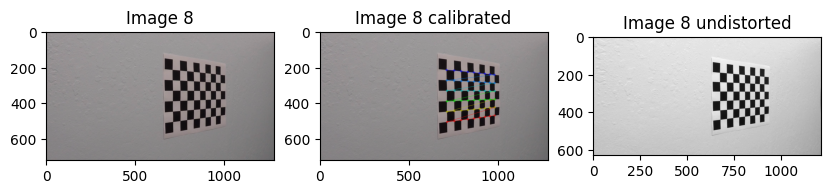

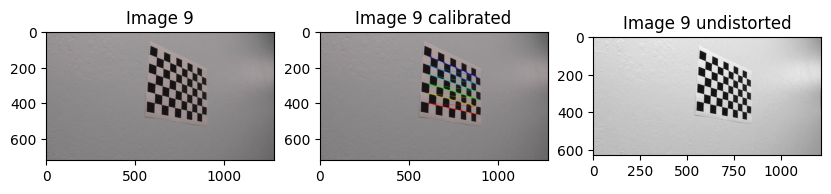

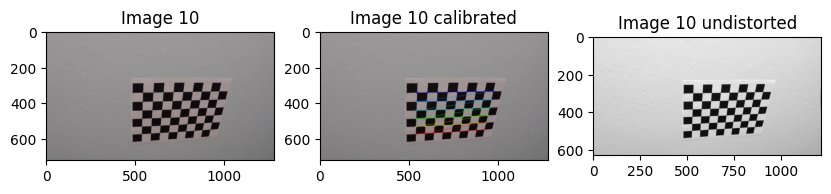

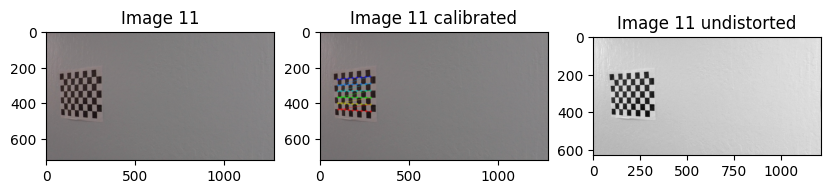

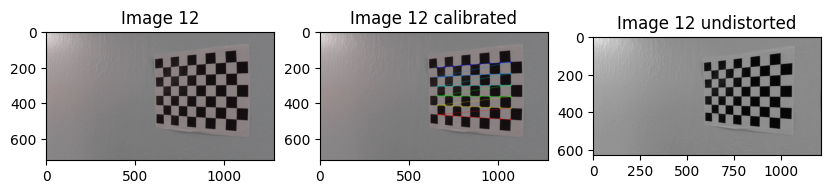

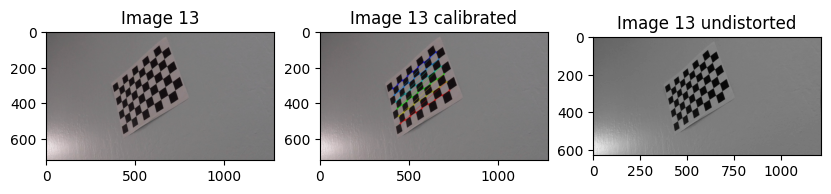

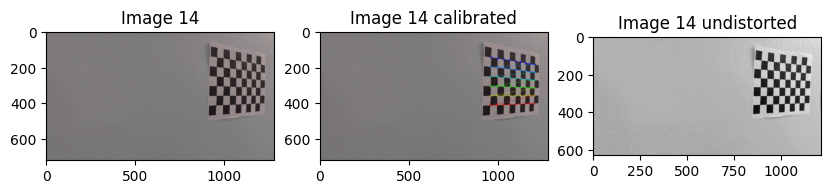

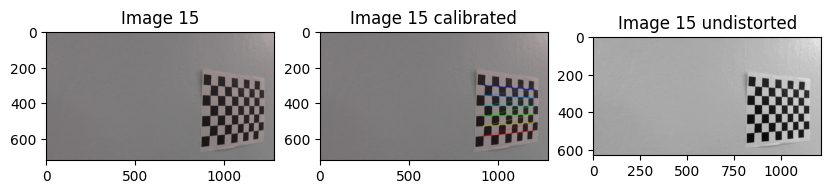

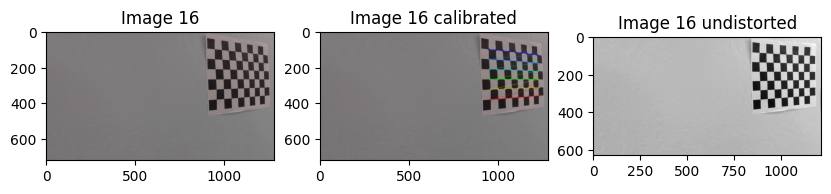

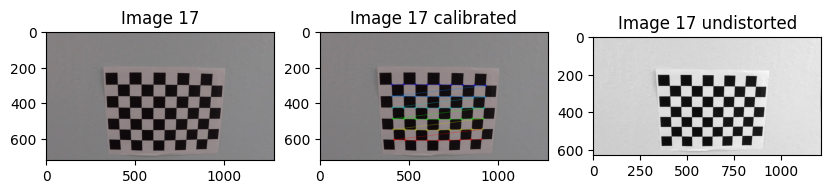

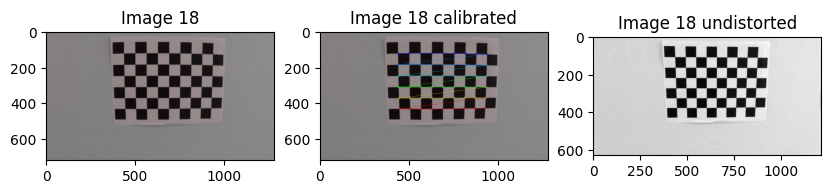

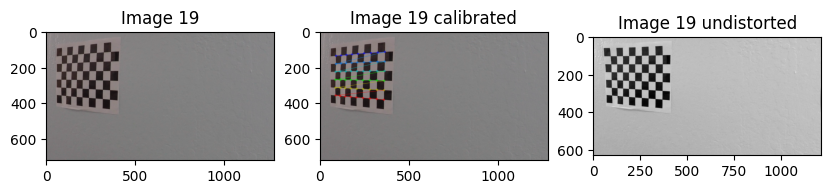

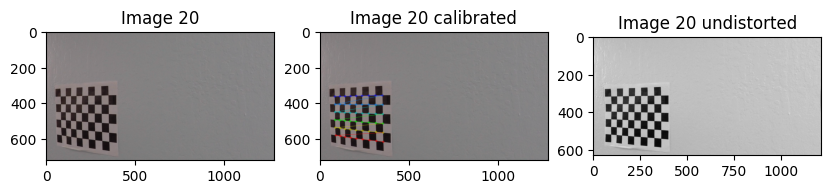

In [23]:
# Define columns and rows for chess board
width = 9
height = 6

# Arrays for obj and image points
objpoints = []
imgpoints = []

objp = np.zeros((width*height, 3), np.float32)
objp[:, :2] = np.mgrid[:width, :height].T.reshape(-1, 2)

# Calibrate image


def calibrate_image(x):
    # Read image and convert to gray
    image_path = './img/Udacity/calib/calibration' + str(x + 1) + '.jpg'
    img = cv2.imread(image_path, -1)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Localte chess board corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    ret, corners = cv2.findChessboardCorners(img, (width, height), None)

    # If corners are found add to obj array -> else return empty image
    if ret == True:
        # Add object points to array
        objpoints.append(objp)

        # Create corners and draw on image
        corners = cv2.cornerSubPix(
            img_gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners)
        drawn = cv2.drawChessboardCorners(img, (width, height), corners, ret)
    else:
        # Return empty image
        drawn = np.zeros_like(img)
    return drawn

# Undistort image with aquired calibrations


def undistort_image(img):
    # Convert to gray and calibrate with found points
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, img_gray.shape[::-1], None, None)

    # Find new camera matrix and undistort with that matrix
    h, w = img_gray.shape[:2]
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    dst = cv2.undistort(img_gray, mtx, dist, None, new_camera_matrix)

    # Crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    return dst


def show_chess_calibration():
    all_images = [None]*20

    # First: calibrate all images
    for x in range(20):
        all_images[x] = []
        all_images[x].append(calibrate_image(x))

    # Then: undistort all images
    for x in range(20):
        image_path = './img/Udacity/calib/calibration' + str(x + 1) + '.jpg'
        img = cv2.imread(image_path, -1)
        all_images[x].append(undistort_image(img))

        # Show original, calibrated image and undistorted image
        plt.figure(figsize=(10, 10))
        show_img(plt, 'Image ' + str(x + 1), img, 3, 1, 'gray')
        show_img(plt, 'Image ' + str(x + 1) + ' calibrated',
                 all_images[x][0], 3, 2, None)
        show_img(plt, 'Image ' + str(x + 1) + ' undistorted',
                 all_images[x][1], 3, 3, 'gray')
        plt.show()


show_chess_calibration()


# Exercise 2: Perspective transformation

Due to the camera perspective, the curvature of the found lane markings will not correspond to the real lane curvature. Therefore, transform the camera perspective images into a bird's eye view that corresponds to the real lane curvature.


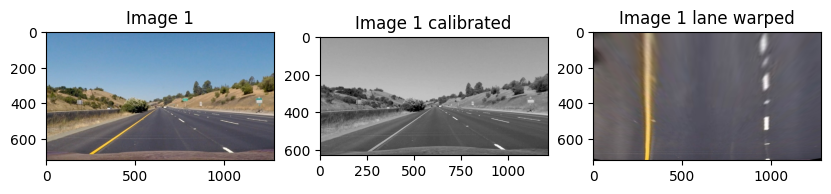

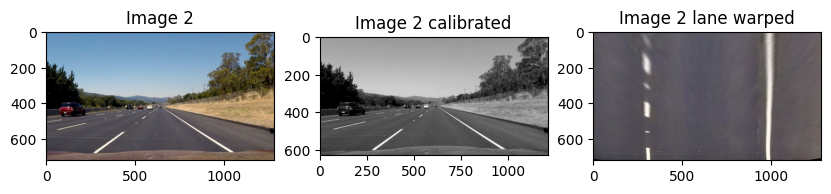

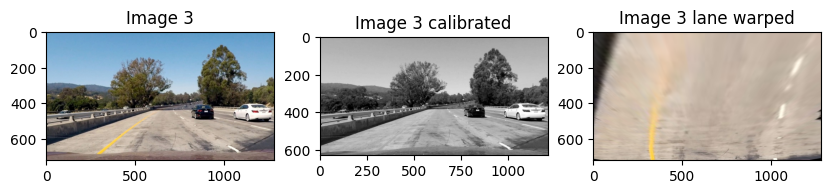

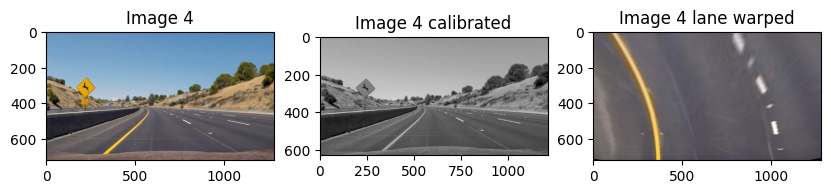

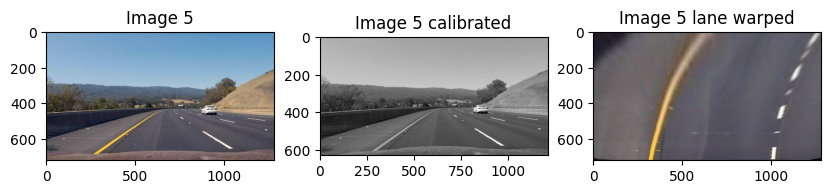

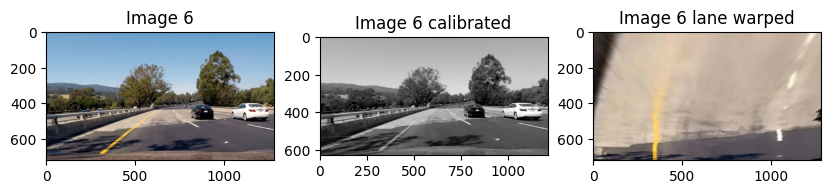

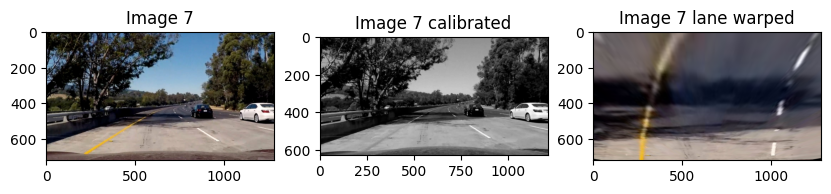

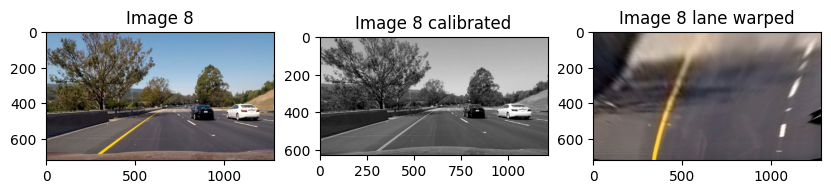

In [24]:
# Calibrating and transforming all Udacity images
def image_calibration_and_transformation():
    for x in range(8):
        # Read image, convert to rgb
        img = cv2.imread('./img/Udacity/image00' + str(x + 1) + '.jpg', -1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # calibrating image
        img_calibrated = undistort_image(img)

        # transforming image so show current lane
        img_warped = warp(img)

        # Show images: Original vs Calibrated vs Warped
        plt.figure(figsize=(10, 10))
        show_img(plt, 'Image ' + str(x + 1), img, 3, 1, 'gray')
        show_img(plt, 'Image ' + str(x + 1) + ' calibrated',
                 img_calibrated, 3, 2, 'gray')
        show_img(plt, 'Image ' + str(x + 1) +
                 ' lane warped', img_warped, 3, 3, None)
        plt.show()


image_calibration_and_transformation()


# Exercise 3: Recognition of lane markings

Recognize the lane markings or lanes on the image sources of Udacity. Apply the procedures known from the lecture. Feel free to use other procedures from other sources as well. The following objectives must be met on the final submission:

- **Segmentation**: restrict the image to the area where the track markers are located.
- **Preprocessing**: perform camera calibration (for Udacity image sources) and perspective transformation.
- **Color spaces, histograms**: identify the track markers in the colors of the specified sources. Provided that other lane markers are found on the image, prioritize those lane markers that border your own lane
- **General**: Image processing must take place in real time --> Target: > 20 FPS.
- **General**: Accelerate processing by further measures Consider further measures (e.g. detection of lane marker in first frames, tracking of lane marker in further frames until lane marker positions change too much).
- **Minimal**: relevant track markers are detected continuously in the video "project_video"
- **Additional**: relevant lane markers are detected in the video "challenge_video" and/or "harder_challenge_video" continuously
- **Additional**: relevant lane markers are applied to the KITTI dataset. What adjustments need to be made for your algorithm to transfer?
- **Additional**: Work out further measures to improve the speed of your algorithm.
- **Additional**: Detect objects in the image and visualize them (e.g. more vehicles, motorcycles, etc.). Please implement the object detection in such a way that it can be deactivated and does not pay into FPS calculation.


### Filters


In [25]:
# Filter image to get yellow and white color spaces
def color_space(img):
    # Convert image to HSV
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Colorspace "yellow" in HSV: (15-40, 80-255, 160-255)
    mask_yellow = cv2.inRange(img_hsv, (15, 80, 160), (40, 255, 255))
    # Colorspace "white" in HSV: (0-255, 0-20, 200-255)
    mask_white = cv2.inRange(img_hsv, (0, 0, 200), (255, 20, 255))
    # Merge white and yellow masks
    masks = cv2.bitwise_or(mask_yellow, mask_white)
    # Return masked image in gray
    return cv2.cvtColor(cv2.bitwise_and(img, img, mask=masks), cv2.COLOR_BGR2GRAY)

# Apply canny filter to image to filter edges


def canny_space(img, lower=80, upper=200):
    # Equalize histogramm with gray image
    equalized_gray_image = cv2.equalizeHist(img)
    # Blur image three times
    equalized_gray_image = cv2.GaussianBlur(equalized_gray_image, (5, 5), 0)
    equalized_gray_image = cv2.GaussianBlur(equalized_gray_image, (5, 5), 0)
    equalized_gray_image = cv2.GaussianBlur(equalized_gray_image, (5, 5), 0)
    # Return image with canny filter
    return cv2.Canny(equalized_gray_image, lower, upper)

# Dilate image (Expands the shapes of the image)


def dilate(img, iterations):
    return cv2.dilate(img, kernel_small, iterations=iterations)

# Erode image (Reduces the shapes of the image)


def erode(img, iterations):
    return cv2.erode(img, kernel_small, iterations=iterations)

# Close image (Removes noises)


def close(img, iterations):
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_large, iterations=iterations)


### Sliding Windows


In [26]:
# Function to create sliding windows to pinpoint the lane direction
def sliding_windows(warped_img, margin=200, minimum=30):
    # Histogram for image to get the position of the lanes
    hist = np.sum(warped_img[warped_img.shape[0]//2:, :], axis=0)

    # Take peaks from left and right side of histogramm to determine the lanes -> starting points and add half margin
    mid = int(hist.shape[0] // 2)
    start_left_x = np.argmax(hist[:mid]) - margin // 2
    start_right_x = np.argmax(hist[mid:]) + mid + margin // 2

    # Window height based on number of windows
    window_height = int(warped_img.shape[0] // sliding_window_count)

    # Calc points that are not zero in images
    nonzero = warped_img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    # Initialize current positions for windows
    left_x_current = start_left_x
    right_x_current = start_right_x

    # Initialize values to be returned -> centers of windows
    lefts_good = np.empty(shape=(1, 1), dtype=int)
    rights_good = np.empty(shape=(1, 1), dtype=int)

    # Go through every window
    for window in range(sliding_window_count):
        # Identify window boundaries in x and y (and right and left)
        window_y_low = warped_img.shape[0] - (window + 1) * window_height
        window_y_high = warped_img.shape[0] - window*window_height

        # Calculate boundaries of the window
        window_x_left_low = left_x_current - margin
        window_x_left_high = left_x_current + margin
        window_x_right_low = right_x_current - margin
        window_x_right_high = right_x_current + margin

        # Identify the pixels that are not zero within window
        left_inds = ((nonzero_y >= window_y_low) & (nonzero_y < window_y_high) & (
            nonzero_x >= window_x_left_low) & (nonzero_x < window_x_left_high)).nonzero()[0]
        right_inds = ((nonzero_y >= window_y_low) & (nonzero_y < window_y_high) & (
            nonzero_x >= window_x_right_low) & (nonzero_x < window_x_right_high)).nonzero()[0]

        # If more than minimum pixels are found -> recenter next window
        if len(left_inds) > minimum:
            left_x_current = int(np.mean(nonzero_x[left_inds]))
        if len(right_inds) > minimum:
            right_x_current = int(np.mean(nonzero_x[right_inds]))

        # Add centers of windows to array
        lefts_good = np.append(lefts_good, left_x_current)
        rights_good = np.append(rights_good, right_x_current)
    return mid, lefts_good, rights_good


### Curve fitting and radius


In [27]:
# Calculate curves of lanes with polyfit function
def calc_curve(left_x, right_x, img):
    y = np.linspace(len(img), 0, sliding_window_count+1).astype(int)
    left = np.polyfit(left_x, y, deg=2)
    right = np.polyfit(right_x, y, deg=2)
    # Calculate radius for curves
    radius = calculate_radius(left, right, left_x, right_x)
    return left, right, radius

# Calculate radius for two lines


def calculate_radius(left_fit, right_fit, left_x, right_x):
    global last_radius
    # Functions for curves by polyfit
    left_fitx = left_fit[0]*left_x**2 + left_fit[1]*left_x + left_fit[2]
    right_fitx = right_fit[0]*right_x**2 + right_fit[1]*right_x + right_fit[2]

    # Calculate functions again with meters for values
    left_fit_curve = np.polyfit(
        left_x*x_meter_per_pixel, left_fitx*y_meter_per_pixel, deg=2)
    right_fit_curve = np.polyfit(
        right_x*x_meter_per_pixel, right_fitx*y_meter_per_pixel, deg=2)

    # radius of curve
    left = calculate_curve_radius(left_fit_curve, left_x)
    right = calculate_curve_radius(right_fit_curve, right_x)

    # Take average from last radius and current radius (if last_radius is not None)
    if (last_radius != None):
        radius = round(np.mean([left, right, last_radius]), 0)
    else:
        radius = round(np.mean([left, right]), 0)

    # Save current radius for next calculation
    last_radius = round(np.mean([left, right]), 0)
    return radius

# Calcurate curve radius | R_curve = ((1 + (2*w2*x + w1)^2)^3/2) / | 2*w2 |


def calculate_curve_radius(street_area, x_range):
    # Take median from x values
    x = np.median(x_range * x_meter_per_pixel)

    # Calculation
    radius = (
        (1 + (2 * street_area[0] * x + street_area[1])**2)**(3/2)) / abs(2 * street_area[0])
    return radius


### Calculate and draw lanes


In [28]:
# Calculate points for lanes
def calculate_lanes(street_area, midpoint, isleft):
    # Calculate extreme value for curve
    # DGL: ax^2 + bx + c -> 2ax + b = 0 -> x = (-b/2)/a
    x_extreme = (-street_area[1]) / 2 / street_area[0]

    # Set lower and upper boundaries
    if(isleft):
        lower = 50
        upper = midpoint
    else:
        lower = midpoint
        upper = 1200

    difference_lower = abs(lower - x_extreme)  # distance left to extreme point
    # distance right to extreme point
    difference_upper = abs(upper - x_extreme)

    # Define x values
    # if left is closer to extreme point -> set extreme point as lower boundary
    if (difference_lower < difference_upper):
        x = np.linspace(x_extreme, upper, 4500).reshape(-1, 1)
    # if right is closer to extreme point -> set extreme point as upper boundary
    else:
        x = np.linspace(lower, x_extreme, 4500).reshape(-1, 1)

    # Get y values from polyfit function
    y = (street_area[0] * (x**2) + street_area[1]
         * x + street_area[2]).reshape(-1, 1)

    # Merge points -> [[p1], [p2]...]
    xycoor = np.concatenate((x, y), axis=1)
    return xycoor

# Draw the calculated lanes


def draw_lanes(img, left_points, right_points, color=255):
    # If color is not changed then it is white. Otherwise any color can be given to this function
    if color != 255:
        zero_img = np.zeros((len(img), len(img[0]), 3))
    else:
        zero_img = np.zeros((len(img), len(img[0])))

    # sort by y values
    left_points = left_points.astype(np.int32)[np.argsort(left_points[:, 1])]
    right_points = right_points.astype(
        np.int32)[np.argsort(right_points[:, 1])][::-1]

    # Draw left and right line in zero_img with polylines
    cv2.polylines(zero_img, [left_points],
                  isClosed=False, color=color, thickness=30)
    cv2.polylines(zero_img, [right_points],
                  isClosed=False, color=color, thickness=30)

    return zero_img


### Bonus: Car detection


In [29]:
class ObjectDetector():
    """Object detector class that detects players and returns bounding boxes
    """

    def __init__(self, cfg_file=None, logger=None, debug=False):
        """Initializes the ObjectDetector. Loads CNN.

        Args:
            cfg_file (cfg, optional): The Config file for the neural network. Defaults to None.
            logger (Logger, optional): Logger. Either giver or created by class. Defaults to None.
            debug (bool, optional): Debug mode logs additional information. Defaults to False.

        Tests:
            check if class can be instancianted
            check if cnn loads correctly
            Scenarios:
            - use correct config file
            - use wrong config file (file format or missing parameters)

        Sources:
            see [2]
        """
        # Create variables
        if cfg_file == None:
            self.cfg_file = os.getcwd() + "\cnn.cfg"
        else:
            self.cfg_file = cfg_file

        if not debug:
            self.debug = False
        else:
            self.debug = debug

        if logger is None:
            # Logging level
            if self.debug:
                logging_level = logging.DEBUG
            else:
                logging_level = logging.INFO

            # Get logger
            self.logger = logging.getLogger(name="Object detection")
            # Set level
            self.logger.setLevel(logging_level)
            # create formatter
            formatter = logging.Formatter(
                '%(asctime)s | %(name)s | %(levelname)s | %(message)s')
            # logging file name
            name = './log/object_detection.log'
            # Logging file handler
            file_handler = logging.FileHandler(name)
            file_handler.setFormatter(formatter)
            # Add components
            self.logger.addHandler(file_handler)
        else:
            self.logger = logger

        self.originalheight = None
        self.originalwidth = None
        self.originalimage = None
        self.blobimage = None

        # Loading neural network
        self.logger.info("Loading CNN...")

        # Load the configuration file
        self.logger.debug(f"Using cfg file: {self.cfg_file}")

        config = configparser.RawConfigParser(allow_no_value=True)
        config.read(self.cfg_file)

        # read from configuration file
        cnn_cfg_path = config.get("CNN", "cfg")
        cnn_names_path = config.get("CNN", "names")
        cnn_weights_path = config.get("CNN", "weights")
        self.logger.debug(
            f"CNN config paths are: config={cnn_cfg_path}, weights={cnn_weights_path}, classes={cnn_names_path}")

        # read cnn params
        # input format for cnn
        self.cnn_param_width = int(config.get("PARAMETERS", "width"))
        self.cnn_param_height = int(config.get("PARAMETERS", "height"))

        # load net
        try:
            self.net = cv2.dnn.readNet(cnn_weights_path, cnn_cfg_path)
        except:
            self.logger.error(
                f"CNN cannot be loaded with cnn_weights_path={cnn_weights_path} and cnn_cfg_path={cnn_cfg_path}. Please check config file.")
            exit(1)

        # add classes
        self.classes = []
        with open(cnn_names_path, "r") as f:
            self.classes = [line.strip() for line in f.readlines()]

        # determine output layers
        layernames = self.net.getLayerNames()
        self.outputlayers = [layernames[i - 1]
                             for i in self.net.getUnconnectedOutLayers()]

        self.logger.info("CNN loaded.")

    def convertimgToBlob(self, image):
        """Converts the given image to a blob.

        Args:
            image (image): A image to convert to blob.

        Returns:
            blob (image): A RGB blob compatible with opencv.

        Tests:
            convert different frames to blob
            Scenarios:
            - test image in blob and assert equals with predefined blob
            - try to convert a corrupt image and assert false
            - try to convert different frame formats to blob and assert if conversion successful

        Sources:
            see [2]
        """
        self.logger.info(
            "convertimgToBlob: Converting numpy image darknet image...")
        # save original image for later use
        self.originalimage = image
        # save original image size for resizing to original size
        self.originalheight, self.originalwidth, channels = image.shape
        # Resize the image to the network size and convert to blob
        self.blobimage = cv2.dnn.blobFromImage(
            image, 0.00392, (self.cnn_param_height, self.cnn_param_width), (0, 0, 0), crop=False)
        return self.blobimage

    def resizeDetectionsToOriginalSize(self, detections, threshhold=0.5):
        """Resize the detected bounding boxes from net size to original size.

        Args:
            detections (list): Detected bounding boxes from cnn
            threshhold (float): Confidence threshhold. Defaults to 0.5.

        Returns:
            resizedboundingboxes (list): Detected bounding boxes resized to original size.
            labels (list): Labels of bounding boxes in the same order.
            conficences (list): Confidences of bounding boxes in the same order

        Tests:
            Predefine a set of unconverted boxes and converted boxes and assert if the result equals the converted boxes.
            Scenarios:
            - different frame sizes 
            - different box sizes
            Check if the function returns all three lists with their respective content (e.g. labels contains a set of strings)
            Scenarios:
            - Correct content --> assert true
            - False content --> assert false

        Source:
            see [2]
        """
        self.logger.info(
            "resizeDetectionsToOriginalSize: Resizing detections...")
        # reshape bounding boxes to original image
        resizedboundingboxes = []
        conficences = []
        labels = []
        for detection in detections:
            for boundingbox in detection:
                # extract bounding box values
                scores = boundingbox[5:]
                classid = np.argmax(scores)
                confidence = scores[classid]
                if confidence > threshhold:
                    self.logger.debug(
                        f"resizeDetectionsToOriginalSize: Original boxes: [{boundingbox[0]}, {boundingbox[1]}, {boundingbox[2]}, {boundingbox[3]}]")
                    # Resize the bounding box to original size
                    xcenter = int(boundingbox[0] * self.originalwidth)
                    ycenter = int(boundingbox[1] * self.originalheight)
                    width = int(boundingbox[2] * self.originalwidth)
                    height = int(boundingbox[3] * self.originalheight)
                    self.logger.debug(
                        f"resizeDetectionsToOriginalSize: Resized boxes: [{xcenter}, {ycenter}, {width}, {height}]")
                    # append to resized bbox array
                    labels.append(str(self.classes[classid]))
                    conficences.append(confidence)
                    resizedboundingboxes.append([xcenter, ycenter,
                                                 width, height])

        self.logger.info("resizeDetectionsToOriginalSize: done")
        return resizedboundingboxes, labels, conficences

    def mergeConvergingBoxes(self, boundingboxes: list, confidences: list, labels: list, threshhold: float = 0.5, nmsthreshhold: float = 0.4):
        """Merges converging bounding boxes.

        Args:
            boundingboxes (list): Bounding boxes to merge.
            confidences (list): Confidences of bounding boxes in the same order.
            labels (list): Labels of bounding boxes in the same order.
            threshhold (float): Confidence threshhold. Defaults to 0.5.
            nmsthreshhold (float): threshhold for convergence. Defaults to 0.4.

        Returns:
            nonconvergingboxes (list): Array of non converging bounding boxes with the following bbox format: [class, confidence [xcenter, ycenter, width, height]].
            originalimage (image): Image with drawn bounding boxes. If debug is enabled.

        Tests:
            Define a set of boxes and assert if output is as expected.
            Scenarios:
            - define set of boxes very close with the same label --> should be merged
            - define set of boxes very close with different labels --> should not be merged

        Source:
            see [2]
        """
        # remove converging bounding boxes
        self.logger.info(f"mergeConvergingBoxes: Removing converging boxes...")
        indexes = cv2.dnn.NMSBoxes(
            boundingboxes, confidences, threshhold, nmsthreshhold)
        self.logger.info(f"...done")

        self.logger.info(f"mergeConvergingBoxes: Merging lists...")
        nonconvergingboxes = []
        for count, index in enumerate(indexes):
            # Summarize to one array
            self.logger.debug(
                f"mergeConvergingBoxes: Summarize bbox: [{labels[index]}, {confidences[index]}, {boundingboxes[index]}]")
            nonconvergingboxes.append(
                [labels[index], confidences[index], boundingboxes[index]])
            self.logger.debug(
                f"mergeConvergingBoxes: Summarized bbox: {nonconvergingboxes[count]}")

            if self.debug == False:
                continue

            # Draw bounding boxes on image for debug purposes
            # Compute top left corner
            x = int(nonconvergingboxes[count][2][0] -
                    nonconvergingboxes[count][2][2] / 2)
            y = int(nonconvergingboxes[count][2][1] -
                    nonconvergingboxes[count][2][3] / 2)
            label = str(labels[index])
            confidence = str(confidences[index])
            # Draw rectangle
            cv2.rectangle(self.originalimage, (x, y),
                          (x + nonconvergingboxes[count][2][2], y + nonconvergingboxes[count][2][3]), (255, 0, 0), 2)
            # Draw label
            cv2.putText(self.originalimage, label, (x, y + 30),
                        cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), 3)
            # Draw confidence
            cv2.putText(self.originalimage, confidence, (x, y + 50),
                        cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), 3)
        self.logger.info(f"...done")

        self.logger.debug(
            f"mergeConvergingBoxes: Non converging bounding boxes: {nonconvergingboxes}")
        return nonconvergingboxes, self.originalimage

    def filterForCar(self, detections: list):
        """ Filters list of detections for bboxes with car class

        Args:
            detections (list): List of all detections

        Returns:
            list: List of detected car

        Tests:
            Define set of boxes with different labels and check if filtering was correct.
            Scenarios:
            - no box with class car --> empty list
            - boxes with cars --> output should be amount of defined boxes with class car
        """
        # Filter detections for car class
        cardetections = []
        for boundingbox in detections:
            if boundingbox[0] == "car":
                cardetections.append(boundingbox)

        return cardetections

    def detectcars(self, frame, thresh: float = 0.90, nmsthresh: float = 0.3):
        """Runs the Yolov3cnn and returns the detected bounding boxes.

        Args:
            frame (image): The image in which objects are to be detected.
            thresh (float, optional): The confidence threshhold. Defaults to 0.5.

        Returns:
            nonconvergingboxes (list): Array of detected car bounding boxes.
            frame (image): Image with detected players.

        Tests:
            Difficult to test because of the neural network. Output may vary with the same input.
            Possible test case: Use test.jpg and check if the center of the detected boxes are in the area of the cars in the picture.
            Easier test but not representative for the functionality of the function. Just test if there is a output.
        """
        # run image detection
        self.logger.info("detectcars: Running Object detection...")
        # Resize image to network size
        self.convertimgToBlob(frame)
        # Run the detection on darknet
        self.net.setInput(self.blobimage)
        detections = self.net.forward(self.outputlayers)
        # Resize the bounding boxes
        boundingboxes, labels, confidences = self.resizeDetectionsToOriginalSize(
            detections)
        # Merge converging boxes
        nonconvergingboxes, frame = self.mergeConvergingBoxes(
            boundingboxes, confidences, labels, thresh, nmsthresh)
        # Filter detections for car
        detectedcars = self.filterForCar(nonconvergingboxes)
        # free the darknet image
        self.logger.info("detectcars: done")
        return detectedcars, frame


detector = ObjectDetector(cfg_file="cnn_320.cfg", debug=True)


### Render lane detection video


In [43]:
def render_lane_detection_video(video_file='project', object_detection=False, src=src, dst=dst, frame_rate_on=True, export_video=False):
    # Open video file
    cap = cv2.VideoCapture('./img/Udacity/' + video_file + '_video.mp4')

    # Check if camera opened successfully
    if (cap.isOpened() == False):
        print("Error opening video stream or file")

    if export_video:
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))

        size = (frame_width, frame_height)

        result = cv2.VideoWriter(video_file + '_export.avi',
                                 cv2.VideoWriter_fourcc(*'MJPG'),
                                 25, size)

    # Start timer for fps counter
    start_timer = time.time() - 0.01
    stop_timer = time.time() + 0.01
    frame_count = -1

    # Read every frame
    while(cap.isOpened()):
        ret, frame = cap.read()

        # Check if there is another frame
        if (frame is None):
            break
        orig = frame.copy()

        # Calculate Frame rate
        frame_count += 1
        ellapsed_time = stop_timer - start_timer
        frame_rate = frame_count / ellapsed_time

        # Calculate curve area only every fourth frame for performance reasons
        if (frame_count % 4 == 0):

            # Step 1: Undistort and warp image
            frame = warp(frame, src, dst)

            # Step 2: Apply color mask and close image for get rid of small disturbances
            color = color_space(frame)
            color = close(color, 10)

            # ONLY FOR CHALLENGE VIDEO! -> dilate and crop color mask
            if(video_file == 'challenge'):
                color = dilate(color, 10)
                ROI = np.array([[(525, 360), (1150, 340), (1150, 720), (900, 720),
                               (700, 550), (350, 720), (115, 720)]], dtype=np.int32)
                color = crop(color, ROI)

            # Step 3: Sliding windows to get curve points
            midpoint, lefts, rights = sliding_windows(color)

            # Step 4: Calculate curve and radius
            left_fit, right_fit, radius = calc_curve(lefts, rights, orig)

            # Stop the timer for the FPS counter, since the visualization should not be included in time measurement
            # (Changed requirement in the task definition)
            stop_timer = time.time()

            # Step 5: Draw two lines along the lanes and transform area back
            # Optional: draw_lanes has an optional fourth argument for color. Just use an [r, g, b] array to set own lan-line color
            AOI = draw_lanes(frame, calculate_lanes(
                left_fit, midpoint, True), calculate_lanes(right_fit, midpoint, False))
            AOI = warp(AOI, dst, src)

        # Overlay street area on every image
        frame = overlay(orig, AOI)

        # If car detection is on: Draw rectangles around cars
        if object_detection:
            deccars, frame = detector.detectcars(frame)

        if ret == True:
            # Add frame rate to video
            if frame_rate_on:
                cv2.putText(frame, "FPS: " + str(round(frame_rate)), (0, 25),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

            if export_video == True:
                result.write(frame)
            else:
                cv2.imshow('Frame', frame)

            # Close video with letter 'q'
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break

    # When everything done, release the video capture object
    cap.release()
    cv2.destroyAllWindows()


### Play real time lane detection video (Project video)

Iterate through every frame from video:

- Calculate frame rate
- Calculate steps for lane detection only every fifth frame (for performance reasons):
  1. Perform undistortion and perspective transformation on image
  2. Apply color mask to detect yellow and white lanes and close image to reduce noise
  3. Apply sliding windows to find points for curve
  4. Calculate curve and radius
  5. Fill area and transform area image back
- Overlap area image on every frame to original
- Show fps count


In [44]:
# Source and destination for perspective transformation
src_project = np.array(
    [[598, 448], [684, 448], [1026, 668], [278, 668]], np.float32)
dst_project = np.array(
    [[300, 0], [980, 0], [980, 720], [300, 720]], np.float32)

# Create and play video
render_lane_detection_video(
    video_file='project', object_detection=False, src=src_project, dst=dst_project, export_video=False)


# Exercise 4: Challenge video (Bonus task 1)


In [39]:
# Source and destination for perspective transformation
src_challenge = np.array(
    [[600, 480], [760, 480], [1026, 700], [278, 700]], np.float32)
dst_challenge = np.array(
    [[300, 0], [980, 0], [980, 720], [300, 720]], np.float32)

# Create and play video
render_lane_detection_video(video_file='challenge', object_detection=False, src=src_challenge, dst=dst_challenge, export_video=False)


# Exercise 5: Object detection (Bonus task 2)


### Play project video with car detection


In [45]:
# Source and destination for perspective transformation
src_project = np.array(
    [[598, 448], [684, 448], [1026, 668], [278, 668]], np.float32)
dst_project = np.array(
    [[300, 0], [980, 0], [980, 720], [300, 720]], np.float32)

# Create and play video
render_lane_detection_video(video_file='project', object_detection=True, src=src_project, dst=dst_project, frame_rate_on=False, export_video=False)


# Exercise 6: Port to Java app for Android smartphones (App)

A separate GitHub repo has been created for the app, which can be accessed via this [link](https://github.com/Patr1ick/Android-LaneDetection).
